# Predicting Grades for Semester 2 of Second Year

In this project I try to figure out which assignments I am likely to find more difficult based on previous results.
And which ones I am likely to do well in.
I have an intuition that the computer science, stats and pratical assignments are easier than the psychology and written ones. But let's see if this is the case.

The dataset includes the following features:
- 'ModuleCode': the identifier code for the module
- 'ModuleName': the name of the module
- 'ModuleType': the field the assessment belongs to (computer science, psychology etc)
- 'AssessmentName': the name of the assessment
- 'DueDate': the date and time the assessment was due
- 'AssessmentType': whether the assessment was an exam or continuous assessment
- 'SubmissionType': what activity the assessment primarily consisted of (written, programming etc)
- 'Score': The grade achieve for the assessment
- 'CreditsWeight': the weight of the assessment for the modules overall score (100 marks is equal to a 5 credit module)
- 'Submitted': the time the assessment was submitted online

In [235]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [178]:
grades = pd.read_csv("grades.csv", sep="\t", encoding="unicode-escape")

In [179]:
unique_modules = grades['ModuleName'].unique()
for module in unique_modules:
    print(module)
    
print(len(unique_modules), 'modules') # should be 17

Systems Organisation
Human Centred Computing
Introduction to Programming & Problem-Solving
Relational Databases
User Experience Design
Research Methods in Psychology I
People & Technology
Research Design & Statistical Analysis
Neuroscience, Attention & Perception
Social Psychology
Web Development
Intermediate Programming & Problem-Solving I
Experimental Design and Statistical Applications II
Psychology of Childhood and Adolescence
Applied Cognition
Research Methods in Psychology II
16 modules


I missed a module when I was inputting the data to the excel sheet. Let me just fix that quick

In [180]:
missing_module = pd.DataFrame([
    ["CS2512","Authoring","Computer Science","Assignment 1","13 Nov 2021 23:30","CA","Written",77,30,"13 Nov 2021 19:56"],
["CS2512","Authoring","Computer Science","Assignment 2","27 Nov 2021 23:30","CA","Programming",83,35,"26 Nov 2021 12:02"],
["CS2512","Authoring","Computer Science","Assignment 3","5 Dec 2021 23:30","CA","Programming",71,35,"28 Nov 2021 16:35",]
], columns=["ModuleCode","ModuleName","ModuleType","AssessmentName","DueDate","AssessmentType","SubmissionType","Score","CreditsWeight","Submitted"])

In [181]:
missing_module

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted
0,CS2512,Authoring,Computer Science,Assignment 1,13 Nov 2021 23:30,CA,Written,77,30,13 Nov 2021 19:56
1,CS2512,Authoring,Computer Science,Assignment 2,27 Nov 2021 23:30,CA,Programming,83,35,26 Nov 2021 12:02
2,CS2512,Authoring,Computer Science,Assignment 3,5 Dec 2021 23:30,CA,Programming,71,35,28 Nov 2021 16:35


In [182]:
grades = pd.concat([grades, missing_module], ignore_index=True, axis="index")

In [183]:
grades.tail(5)

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments
52,AP2044,Applied Cognition,Psychology,Written Exam,15 Dec 2021 by 18:36,Exam,Written,65,100,15 Dec 2021 at 18:02,NaN
53,AP2114,Research Methods in Psychology II,Psychology,Assignment 1: Thematic Analysis,12/10/2021 11:00,CA,Written,68,50,12/10/2021 07:30,NaN
54,CS2512,Authoring,Computer Science,Assignment 1,13 Nov 2021 23:30,CA,Written,77,30,13 Nov 2021 19:56,NaN
55,CS2512,Authoring,Computer Science,Assignment 2,27 Nov 2021 23:30,CA,Programming,83,35,26 Nov 2021 12:02,NaN
56,CS2512,Authoring,Computer Science,Assignment 3,5 Dec 2021 23:30,CA,Programming,71,35,28 Nov 2021 16:35,NaN


Everything is looking good so far. Notice the different time formats. Let's deal with that!

In [184]:
from datetime import datetime

In [185]:
date_formats = ("%d %b %Y by %H:%S", "%d %b %Y at %H:%S", "%d/%m/%Y %H:%S", "%d %b %Y %H:%S")
issues = []
def parse(date):
    for date_format in date_formats:
        try:
            return datetime.strptime(date, date_format).strftime("%d/%m/%Y %H:%S")
        except ValueError:
            issues.append(date)
    
print(issues)

grades["DueDate"] = grades["DueDate"].apply(lambda date: parse(date))

[]


In [186]:
grades["DueDate"] = pd.to_datetime(grades["DueDate"], dayfirst=True)
grades["Submitted"] = pd.to_datetime(grades["Submitted"], dayfirst=True)

Let's sort the assignments by the time they were submitted

In [187]:
grades = grades.sort_values("Submitted")

In [188]:
grades.head()

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments
14,CS1021,Relational Databases,Computer Science,Lab Assignment 1,2020-10-23 23:59:00,CA,Programming,83,6,2020-10-19 16:20:00,NaN
22,AP1104,Research Methods in Psychology I,Psychology,Prac 1 Research Paper Worksheet,2020-11-09 18:00:00,CA,Written,70,10,2020-10-31 08:41:00,NaN
0,CS1111,Systems Organisation,Computer Science,Assessment 1 - Overview Material Questions,2020-11-08 23:59:00,CA,Written,100,10,2020-11-07 08:50:00,NaN
32,AP1040,Research Design & Statistical Analysis,Statistics,Assignment 1,2020-11-09 11:00:00,CA,Written,87,10,2020-11-08 08:29:00,NaN
15,CS1021,Relational Databases,Computer Science,Lab Assignment 2,2020-11-14 23:59:00,CA,Programming,83,6,2020-11-08 13:24:00,NaN


# Exploratory Analysis

I want to find my average score overall
but getting the mean of the scores doesn't account for the fact that the assignments are worth different amounts of credit

In [189]:
round(grades['Score'].mean(),2) 

82.72

so the 82% is inflated. Fortunately the CreditsWeight column lets us deal with that.

In [190]:
grades["NumberCreditsEarned"] = grades["CreditsWeight"] * (grades["Score"] / 100)
round(grades["NumberCreditsEarned"].sum() / grades["CreditsWeight"].sum(),2) * 100

78.0

78% is not bad at all. 

If we look at the median, we see the distribution is negatively skewed.

In [191]:
grades['Score'].median()

84.0

<AxesSubplot:ylabel='Density'>

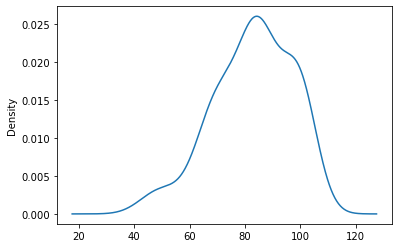

In [192]:
grades["Score"].sort_values().plot(kind="kde")

### How do each of the semesters compare?

In [193]:
# Semester 1
semester1_credits_earned = grades[grades["DueDate"].between("2020-9-01","2020-12-31")]["NumberCreditsEarned"].sum()
semester1_credits_total = grades[grades["DueDate"].between("2020-9-01","2020-12-31")]["CreditsWeight"].sum()
round(semester1_credits_earned / semester1_credits_total,2)

0.79

In [194]:
# Semester 2
semester2_credits_earned = grades[grades["DueDate"].between("2021-1-1","2021-6-1")]["NumberCreditsEarned"].sum()
semester2_credits_total = grades[grades["DueDate"].between("2021-1-1","2021-6-1")]["CreditsWeight"].sum()
round(semester2_credits_earned / semester2_credits_total,2)

0.78

In [195]:
# Semester 3
semester3_credits_earned = grades[grades["DueDate"].between("2021-9-1","2021-12-31")]["NumberCreditsEarned"].sum()
semester3_credits_total = grades[grades["DueDate"].between("2021-9-1","2021-12-31")]["CreditsWeight"].sum()
round(semester3_credits_earned / semester3_credits_total,2)

0.77

It looks like each semester is getting progressively harder, as expected.

I want to see if we can shift that distribution by focusing on my weakest points.

Let's see what my 10 worst grades have been so far.

In [196]:
worst_grades = grades["Score"].nsmallest(10).index

In [197]:
grades.loc[worst_grades]

,ModuleCode,ModuleName,ModuleType,AssessmentName,DueDate,AssessmentType,SubmissionType,Score,CreditsWeight,Submitted,Comments,NumberCreditsEarned
44,CS2012,Web Development,Computer Science,Class Test,2021-12-03 11:30:00,Exam,Quiz,45,25,2021-12-03 10:16:00,NaN,11.25
6,CS1111,Systems Organisation,Computer Science,Class Test,2020-12-17 16:00:00,Exam,Written,50,40,2020-12-17 15:44:00,NaN,20.00
38,AP1035,"Neuroscience, Attention & Perception",Psychology,Essay 1,2021-05-04 18:00:00,CA,Written,52,50,2021-05-04 12:21:00,NaN,26.00
40,AP1022,Social Psychology,Psychology,Essay,2021-04-30 15:00:00,CA,Written,62,100,2021-04-30 10:32:00,NaN,62.00
39,AP1035,"Neuroscience, Attention & Perception",Psychology,Essay 2,2021-05-04 18:00:00,CA,Written,62,50,2021-05-04 12:21:00,NaN,31.00
52,AP2044,Applied Cognition,Psychology,Written Exam,2021-12-15 18:36:00,Exam,Written,65,100,2021-12-15 18:02:00,NaN,65.00
31,AP1046,People & Technology,Psychology,Assignment 2,2020-12-14 11:00:00,CA,Written,68,50,2020-12-11 09:58:00,NaN,34.00
53,AP2114,Research Methods in Psychology II,Psychology,Assignment 1: Thematic Analysis,2021-10-12 11:00:00,CA,Written,68,50,2021-10-12 07:30:00,NaN,34.00
49,AP2046,Experimental Design and Statistical Applicatio...,Statistics,Practical Report,2021-12-13 11:00:00,CA,Written,68,50,2021-12-12 11:25:00,NaN,34.00
51,AP2045,Psychology of Childhood and Adolescence,Psychology,Essay,2021-12-21 11:00:00,CA,Written,68,100,2021-12-21 05:21:00,NaN,68.00


With the exception of two computer science assessments (both of which were exams) it appears overall psychology is my weakest area. But let's confirm this.

In [198]:
grades["ModuleType"] = grades["ModuleType"].astype("category")
grades["AssessmentType"] = grades["AssessmentType"].astype("category")
grades["SubmissionType"] = grades["SubmissionType"].astype("category")

In [199]:
grades.groupby("ModuleType")["Score"].mean().sort_values()

ModuleType
Psychology          72.437500
UX                  75.000000
Statistics          85.000000
Computer Science    88.827586
Name: Score, dtype: float64

In [200]:
grades.groupby("AssessmentType")["Score"].mean().sort_values()

AssessmentType
Exam    71.625000
CA      84.530612
Name: Score, dtype: float64

In [201]:
grades.groupby("SubmissionType")["Score"].mean().sort_values()

SubmissionType
Written         74.240000
Quiz            81.428571
Presentation    84.000000
Programming     91.875000
Name: Score, dtype: float64

Based on this analysis. Written psychology exams are the weak spot. Not surprising really. 
Practical computer science continuous assessments are the strongest. 💪🏻

I just submitted a python assignment. What mark can I hope to get on average based on previous python modules?

In [202]:
python_modules = grades["ModuleName"].isin(["Introduction to Programming & Problem-Solving","Intermediate Programming & Problem-Solving I"])

In [203]:
round(grades[python_modules]["NumberCreditsEarned"].sum() / grades[python_modules]["CreditsWeight"].sum() * 100,2)

87.92

Answer: about 88%

# Building the Logistic Regression Model

Let's see if we can build a model to predict future grades.

First we need to deal with some of the categorical values by turning them into dummy variables making sure to deal with multicollinearity and scale the variables.

In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [205]:
cat_features = ["ModuleType","AssessmentType","SubmissionType"]
grades_dummies = pd.get_dummies(grades, columns=cat_features, drop_first=True)

In [206]:
X = grades_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']]
y = grades_dummies['Score']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=28)
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [208]:
predictions = pipe.predict(X_test)

As we can see below the model did a pretty terrible job of predicting correctly from the data provided. Using categorical values to predict a numerical output means theres a lot of noise. For my purposes 100% accuracy is not neccessary. A ball park figure is good enough to take action on.

In [209]:
print(classification_report(y_test,predictions, zero_division=0))

              precision    recall  f1-score   support

          50       0.00      0.00      0.00         1
          62       0.00      0.00      0.00         1
          68       0.50      1.00      0.67         2
          71       0.00      0.00      0.00         2
          73       0.00      0.00      0.00         1
          74       0.00      0.00      0.00         0
          77       0.00      0.00      0.00         1
          78       0.00      0.00      0.00         0
          80       1.00      1.00      1.00         1
          81       0.00      0.00      0.00         2
          83       0.00      0.00      0.00         1
          84       0.00      0.00      0.00         1
          85       1.00      1.00      1.00         1
          87       0.00      0.00      0.00         1
          88       0.00      0.00      0.00         0
          90       0.00      0.00      0.00         1
          97       0.00      0.00      0.00         0
         100       0.67    

# How Will Semester 2 Go?

In [210]:
semester_2 = pd.read_csv("semester2.csv")

In [211]:
semester_2_dummies = pd.get_dummies(semester_2, columns=cat_features)

In [212]:
predicted_grades = semester_2_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']]
semester_2['Predicted'] = pipe.predict(predicted_grades)

These are the assignments most likely to give me trouble this semester.

In [213]:
semester_2[["ModuleName","AssessmentName", "Predicted"]].sort_values("Predicted").head(7)

,ModuleName,AssessmentName,Predicted
1,Learning & Behaviour,MCQ,45
0,Learning & Behaviour,Essay,68
2,Research Methods in Psychology II,Prac 4 Experiment,68
3,Research Methods in Psychology II,Prac 5 Research Proposal,68
5,Social Computing,Blogs,68
6,Social Computing,Social Analysis Report,68
11,Design for Human Centred Computing,Project Assignment 1,74


In [214]:
semester_2["PredictedCreditsEarned"] = semester_2["CreditsWeight"] * (semester_2["Predicted"] / 100)
round(semester_2["PredictedCreditsEarned"].sum() / semester_2["CreditsWeight"].sum(),2) * 100

73.0

According to the model I should get an average grade of 73%

Although I am a little surprised by the prediction for the Learning & Behavior MCQ

In [215]:
quizzes = grades[grades["SubmissionType"] == 'Quiz']
quizzes[["ModuleName", "ModuleType","AssessmentType","CreditsWeight","Score"]]

,ModuleName,ModuleType,AssessmentType,CreditsWeight,Score
9,Introduction to Programming & Problem-Solving,Computer Science,CA,15,85
10,Introduction to Programming & Problem-Solving,Computer Science,CA,20,85
34,Research Design & Statistical Analysis,Statistics,CA,10,85
35,Research Design & Statistical Analysis,Statistics,CA,10,100
36,Research Design & Statistical Analysis,Statistics,CA,10,90
44,Web Development,Computer Science,Exam,25,45
50,Experimental Design and Statistical Applicatio...,Statistics,Exam,50,80


Overall I didn't do too badly in quizzes. 
The model seems to have a lot of room for improvement and I have a lot to learn.

In [216]:
semester_2[["ModuleName","Predicted"]].groupby("ModuleName").mean().sort_values("Predicted")

,Predicted
ModuleName,
Learning & Behaviour,56.500000
Social Computing,68.000000
Research Methods in Psychology II,73.666667
Design for Human Centred Computing,74.000000
Intermediate Programming & Problem Solving II,96.250000


## Conclusion
I know Dr Linehan can be a tough marker. I'll put a little extra attention in Learning & Behavior. My intuition about psychology versus computer science seems to be right and this semesters focus on more written psychology will make it just that little bit harder than last semester. But I am ready for it.

In [217]:
X = grades_dummies[['CreditsWeight','ModuleType_Psychology', 'ModuleType_Statistics', 'ModuleType_UX','AssessmentType_Exam', 'SubmissionType_Programming', 'SubmissionType_Quiz', 'SubmissionType_Written']].values
y = grades_dummies['Score'].values

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)

In [219]:
from sklearn.preprocessing import MinMaxScaler

In [220]:
scaler = MinMaxScaler()

In [221]:
scaler.fit(X_train)

MinMaxScaler()

In [222]:
X_train = scaler.transform(X_train)

In [223]:
X_test = scaler.transform(X_test)

In [224]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [225]:
model = Sequential()

model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(1))

model.compile(optimizer='rmsprop', loss='mse')

In [226]:
model.fit(x=X_train, y=y_train, epochs=500)

Epoch 1/500
2/2 [==============================] - 0s 999us/step - loss: 7386.6265
Epoch 2/500
2/2 [==============================] - 0s 1ms/step - loss: 7373.3696
Epoch 3/500
2/2 [==============================] - 0s 998us/step - loss: 7365.4097
Epoch 4/500
2/2 [==============================] - 0s 998us/step - loss: 7358.9697
Epoch 5/500
2/2 [==============================] - 0s 1ms/step - loss: 7353.6587
Epoch 6/500
2/2 [==============================] - 0s 1ms/step - loss: 7348.4102
Epoch 7/500
2/2 [==============================] - 0s 996us/step - loss: 7344.0439
Epoch 8/500
2/2 [==============================] - 0s 997us/step - loss: 7338.3911
Epoch 9/500
2/2 [==============================] - 0s 2ms/step - loss: 7333.8188
Epoch 10/500
2/2 [==============================] - 0s 2ms/step - loss: 7329.8198
Epoch 11/500
2/2 [==============================] - 0s 998us/step - loss: 7324.7188
Epoch 12/500
2/2 [==============================] - 0s 2ms/step - loss: 7319.7085
Epoch 13/500


2/2 [==============================] - 0s 1ms/step - loss: 6385.1919
Epoch 100/500
2/2 [==============================] - 0s 1ms/step - loss: 6365.8911
Epoch 101/500
2/2 [==============================] - 0s 1ms/step - loss: 6346.0576
Epoch 102/500
2/2 [==============================] - 0s 994us/step - loss: 6325.1709
Epoch 103/500
2/2 [==============================] - 0s 996us/step - loss: 6304.1841
Epoch 104/500
2/2 [==============================] - 0s 2ms/step - loss: 6284.0259
Epoch 105/500
2/2 [==============================] - 0s 2ms/step - loss: 6264.2349
Epoch 106/500
2/2 [==============================] - 0s 1ms/step - loss: 6243.7041
Epoch 107/500
2/2 [==============================] - 0s 999us/step - loss: 6222.8467
Epoch 108/500
2/2 [==============================] - 0s 1ms/step - loss: 6200.9937
Epoch 109/500
2/2 [==============================] - 0s 1ms/step - loss: 6179.8789
Epoch 110/500
2/2 [==============================] - 0s 1ms/step - loss: 6158.1201
Epoch 111/50

2/2 [==============================] - 0s 995us/step - loss: 3297.3911
Epoch 197/500
2/2 [==============================] - 0s 1ms/step - loss: 3254.7209
Epoch 198/500
2/2 [==============================] - 0s 2ms/step - loss: 3211.7549
Epoch 199/500
2/2 [==============================] - 0s 997us/step - loss: 3167.5898
Epoch 200/500
2/2 [==============================] - 0s 1ms/step - loss: 3126.0017
Epoch 201/500
2/2 [==============================] - 0s 2ms/step - loss: 3084.4705
Epoch 202/500
2/2 [==============================] - 0s 997us/step - loss: 3042.9661
Epoch 203/500
2/2 [==============================] - 0s 1ms/step - loss: 3000.1021
Epoch 204/500
2/2 [==============================] - 0s 2ms/step - loss: 2957.5837
Epoch 205/500
2/2 [==============================] - 0s 2ms/step - loss: 2912.8254
Epoch 206/500
2/2 [==============================] - 0s 999us/step - loss: 2870.8005
Epoch 207/500
2/2 [==============================] - 0s 1ms/step - loss: 2830.2407
Epoch 208/

2/2 [==============================] - 0s 999us/step - loss: 221.7997
Epoch 295/500
2/2 [==============================] - 0s 999us/step - loss: 217.3154
Epoch 296/500
2/2 [==============================] - 0s 997us/step - loss: 210.2086
Epoch 297/500
2/2 [==============================] - 0s 1ms/step - loss: 205.2231
Epoch 298/500
2/2 [==============================] - 0s 2ms/step - loss: 201.3043
Epoch 299/500
2/2 [==============================] - 0s 1ms/step - loss: 196.4656
Epoch 300/500
2/2 [==============================] - 0s 2ms/step - loss: 193.5910
Epoch 301/500
2/2 [==============================] - 0s 998us/step - loss: 191.2194
Epoch 302/500
2/2 [==============================] - 0s 999us/step - loss: 189.8124
Epoch 303/500
2/2 [==============================] - 0s 1ms/step - loss: 188.0690
Epoch 304/500
2/2 [==============================] - 0s 996us/step - loss: 184.8679
Epoch 305/500
2/2 [==============================] - 0s 997us/step - loss: 181.7879
Epoch 306/500
2/

2/2 [==============================] - 0s 994us/step - loss: 116.8267
Epoch 393/500
2/2 [==============================] - 0s 1ms/step - loss: 116.0939
Epoch 394/500
2/2 [==============================] - 0s 1ms/step - loss: 115.6370
Epoch 395/500
2/2 [==============================] - 0s 998us/step - loss: 115.7714
Epoch 396/500
2/2 [==============================] - 0s 999us/step - loss: 115.2297
Epoch 397/500
2/2 [==============================] - 0s 998us/step - loss: 114.6592
Epoch 398/500
2/2 [==============================] - 0s 996us/step - loss: 114.5289
Epoch 399/500
2/2 [==============================] - 0s 999us/step - loss: 113.9297
Epoch 400/500
2/2 [==============================] - 0s 997us/step - loss: 113.5332
Epoch 401/500
2/2 [==============================] - 0s 1ms/step - loss: 113.3249
Epoch 402/500
2/2 [==============================] - 0s 999us/step - loss: 112.9760
Epoch 403/500
2/2 [==============================] - 0s 999us/step - loss: 113.0674
Epoch 404/50

2/2 [==============================] - 0s 998us/step - loss: 93.0528
Epoch 492/500
2/2 [==============================] - 0s 1ms/step - loss: 92.6671
Epoch 493/500
2/2 [==============================] - 0s 996us/step - loss: 92.4296
Epoch 494/500
2/2 [==============================] - 0s 998us/step - loss: 92.2705
Epoch 495/500
2/2 [==============================] - 0s 1000us/step - loss: 92.2634
Epoch 496/500
2/2 [==============================] - 0s 996us/step - loss: 92.4906
Epoch 497/500
2/2 [==============================] - 0s 2ms/step - loss: 92.4657
Epoch 498/500
2/2 [==============================] - 0s 1ms/step - loss: 91.9894
Epoch 499/500
2/2 [==============================] - 0s 1ms/step - loss: 92.0958
Epoch 500/500
2/2 [==============================] - 0s 1ms/step - loss: 92.0863


<AxesSubplot:>

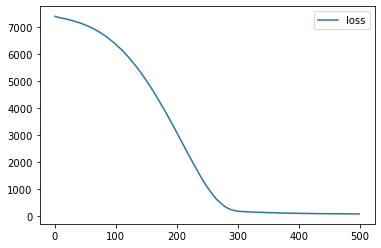

In [227]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [228]:
model.evaluate(X_test, y_test, verbose=0)

352.398193359375

In [229]:
model.evaluate(X_train, y_train, verbose=0)

91.64094543457031

In [274]:
test_predictions = model.predict(X_test)

In [275]:
test_predictions = pd.Series(test_predictions.reshape(18,))

In [276]:
prediction_df = pd.DataFrame(y_test, columns=["Test True Y"])

In [277]:
prediction_df = pd.concat([prediction_df, test_predictions], axis=1)

In [279]:
prediction_df.rename(columns={prediction_df.columns[1] : "Model Predictions"} , inplace=True)

In [280]:
prediction_df

,Test True Y,Model Predictions
0,62,71.128128
1,77,54.002987
2,71,114.406097
3,50,48.858570
4,68,71.035385
5,84,63.083836
6,80,77.664978
7,100,53.965889
8,81,71.016830
9,90,82.753746


In [281]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [283]:
mean_absolute_error(prediction_df["Test True Y"], prediction_df["Model Predictions"])

13.36010487874349

In [285]:
mean_squared_error(prediction_df["Test True Y"], prediction_df["Model Predictions"]) **0.5

18.77227223879292

In [288]:
semester2 = scaler.transform(predicted_grades)

D:\Anaconda\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [298]:
semester_2["Neural_Net_Predictions"] = model.predict(semester2)

In [299]:
semester_2[["ModuleName","AssessmentName", "Predicted", "Neural_Net_Predictions"]]

,ModuleName,AssessmentName,Predicted,Neural_Net_Predictions
0,Learning & Behaviour,Essay,68,71.035385
1,Learning & Behaviour,MCQ,45,72.590492
2,Research Methods in Psychology II,Prac 4 Experiment,68,82.827942
3,Research Methods in Psychology II,Prac 5 Research Proposal,68,71.035385
4,Research Methods in Psychology II,Prac 6 Presentation,85,59.875458
5,Social Computing,Blogs,68,71.035385
6,Social Computing,Social Analysis Report,68,71.035385
7,Intermediate Programming & Problem Solving II,Project Part 1,100,94.193146
8,Intermediate Programming & Problem Solving II,Project Part 2,100,94.165314
9,Intermediate Programming & Problem Solving II,Project Part 3,100,94.193146
